# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

**Шаги для выбора локации:**

В избранном регионе ищут месторождения, для каждого определяют значения признаков;

Строят модель и оценивают объём запасов;

Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;

Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: 
/datasets/geo_data_0.csv. 
/datasets/geo_data_1.csv. 
/datasets/geo_data_2.csv. 

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:** 
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
BUDGET = 10000000000 # бюджет на регион
N = 500 # число скважин для исследолвания
COUNT = 200 # число скважин для разработки
COST_BAR = 450000 # стоимость 1000 баррелей

## Загрузка и подготовка данных

### Напишем функцию для получения информации о датасете (вывод первых пяти срок, общей информации методом info(), описания информации в столбцах методом discribe(), построение гистограмм для визуализации распределения данных в столбцах).

In [3]:
def get_info(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    display(data.duplicated().sum())
    display(data.isna().sum())
    display(data['id'].value_counts())
    display(data.corr())
    data.hist(figsize=(8, 8))

### Cчитываем данные из файлов и сохраняем их в переменные  df_0, df_1 b df_2 соответсвенно, получаем общую информацию о датафреймах с помощью функции get_info(data)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


0

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

TtcGQ    2
74z30    2
fiKDv    2
HZww2    2
Tdehs    2
        ..
kYmYL    1
7CgA5    1
P47wH    1
5GDxV    1
kA5kc    1
Name: id, Length: 99990, dtype: int64

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


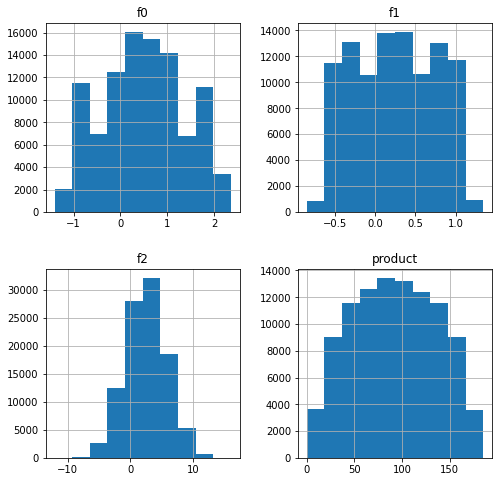

In [4]:
#df_0 = pd.read_csv('D:\Мои Документы\Desktop\Материалы по учебе\Машинное обучение в бизнесе\geo_data_0.csv')
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
get_info(df_0)

In [5]:
df_0.query('id == "bxg6G" or id=="A5aEY"')

,id,f0,f1,f2,product
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


#### Вывод: Проанализировав наличие явных дубликатов и неявных дубликатов, можно сказать следующее. Явных дубликатов нет, но встречаются скважины с одинаковым id. Так как при этом яных дубликатов нет и при выборочной прооверке видно, что данные разные, видимо произошла ошибка в маркеровке скважин, поэтому данные оставляем, для обучения и дальнейших исследований id  как таковой роли не играет. Корреляционной зависимости между признаками нет или она небольшая.

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


0

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

wt4Uk    2
LHZR0    2
5ltQ6    2
bfPNe    2
kNqWQ    1
        ..
ChYIx    1
KD8cr    1
gDOtu    1
KGUe3    1
UziMP    1
Name: id, Length: 99996, dtype: int64

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


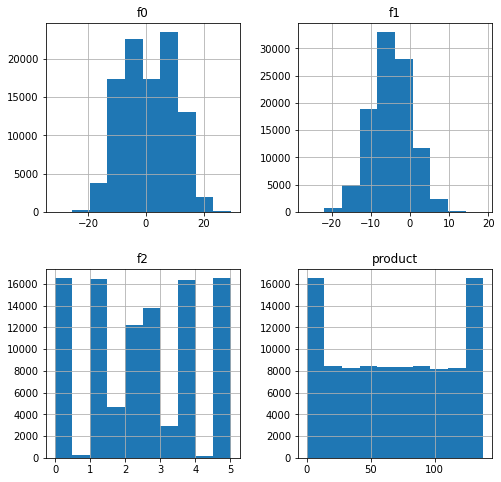

In [6]:
#df_1 = pd.read_csv('D:\Мои Документы\Desktop\Материалы по учебе\Машинное обучение в бизнесе\geo_data_1.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
get_info(df_1)

In [7]:
df_1.query('id == "5ltQ6" or id=="wt4Uk"')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


#### Вывод: Проанализировав наличие явных дубликатов и неявных дубликатов, можно сказать следующее. Явных дубликатов нет, но встречаются скважины с одинаковым id. Так как при этом яных дубликатов нет и при выборочной прооверке видно, что данные разные, видимо произошла ошибка в маркеровке скважин, поэтому данные оставляем, для обучения и дальнейших исследований id  как таковой роли не играет. Корреляционной зависимости между признаками нет. Распределение признака  f2 и данных в столбце product далеко от нормального, но при этом выбрасов в них нет. Затрудняюсь ответить, чем это вызвано, особенно в отношении стьолбца f2, т.к. вообще нет данных что это. 

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


0

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

xCHr8    2
Vcm5J    2
VF7Jo    2
KUPhW    2
x33SR    1
        ..
G6H0h    1
9lUmg    1
h0pLd    1
QJxi5    1
GOtt9    1
Name: id, Length: 99996, dtype: int64

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


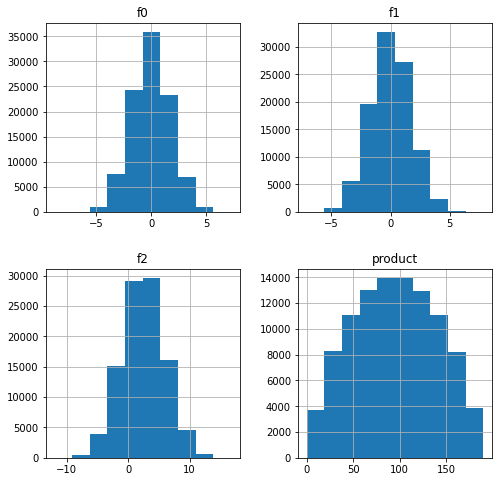

In [8]:
#df_2 = pd.read_csv('D:\Мои Документы\Desktop\Материалы по учебе\Машинное обучение в бизнесе\geo_data_2.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')
get_info(df_2)

#### Вывод: В таблицах во всех столбцах нет пропусков, распределение данных в целом выглядят адекватно, критичных выбросов нет, поэтому оставляем все данные.

### Напишем функцию для разделения датафреймов на признаки и целевой признак

In [9]:
def separate_features_target(data):
    data_target = data['product']
    data_features = data.drop(['id', 'product'], axis=1)
    return data_target, data_features

### Разделим датофреймы на признаки и целевой признак с помощью функции separate_features_target

In [10]:
df_0_target, df_0_features = separate_features_target (data=df_0)
print(df_0_features.shape)
df_0_target.shape

(100000, 3)


(100000,)

In [11]:
df_1_target, df_1_features = separate_features_target (data=df_1)
print(df_1_features.shape)
df_1_target.shape

(100000, 3)


(100000,)

In [12]:
df_2_target, df_2_features = separate_features_target (data=df_2)
print(df_2_features.shape)
df_2_target.shape

(100000, 3)


(100000,)

#### Для дальнейшего обучения модели разбили данные в трех дататфреймах на две выборки: признаки и целевой признак. Из признаков удалили также столбец с 'id', который не значим.

#### Данные загружены, проведенны исследования на наличе пропусков, явных и неявных дубликатов, проведена оценка коррелируемости признаков.  Для дальнейшего обучения модели разбили данные в трех дататфреймах на две выборки: признаки и целевой признак. Из признаков удалили также столбец с 'id', который не значим.

## Обучение и проверка модели

### Напишем функцию для разбивки датафреймов на обучающую и валидационную выборку в соотношении 75:25, обучение модели линейной регрессии на обучающей выборке, получения предсказаний на валидационной, подсчета RMSE модели и среднего запаса предсказанного сырья, также считаем rmse константной модели (для оценки адекватности). На выходе функция возвращает: модель, правильные ответы на валидационной выборке, предсказания на валидационной выборке, rmse модели, средний запас предсказанного сырья и rmse константной модели

In [13]:
def learn_check(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    prediction_constant = pd.Series(target_train.mean(), index=target_valid.index)
    rmse = mean_squared_error(target_valid, predictions)**0.5
    rmse_const = mean_squared_error(target_valid, prediction_constant)**0.5
    mean_product =  predictions.mean()
    return model, target_valid, predictions, rmse, mean_product, rmse_const

### Обучаем и проверяем модель для региона 0. Для удобства дальнейшей работы сохраняем предсказания модели в виде Series (сохраняя индексы, чтобы потом можно было понять, о каких скважинах в регионе идет речь). Проверяем, что получилось.

In [14]:
model_0, df_0_target_valid, prediction_valid_0, rmse_0, mean_product_0, rmse_const_0  = learn_check(features=df_0_features, 
                                                                                                    target=df_0_target)
prediction_valid_0 = pd.Series(prediction_valid_0, index=df_0_target_valid.index)
print(df_0_target_valid.shape)
print(df_0_target_valid.head(10))
print(prediction_valid_0.head(10))
print('rmse модели:', rmse_0)
print('rmse константной модели:', rmse_const_0)
print('Cредний запас предсказанного сырья:', mean_product_0)

(25000,)
71751     10.038645
80493    114.551489
2655     132.603635
53233    169.072125
91141    122.325180
9539      37.735331
8482     139.227191
30284     72.491987
66393     11.465993
99584    110.562031
Name: product, dtype: float64
71751     95.894952
80493     77.572583
2655      77.892640
53233     90.175134
91141     70.510088
9539      69.127076
8482     125.106759
30284     87.643849
66393     86.035871
99584     98.655311
dtype: float64
rmse модели: 37.5794217150813
rmse константной модели: 44.289591053907365
Cредний запас предсказанного сырья: 92.59256778438035


### Обучаем и проверяем модель для региона 1.

In [15]:
model_1, df_1_target_valid, prediction_valid_1, rmse_1, mean_product_1, rmse_const_1  = learn_check(features=df_1_features, 
                                                                                                    target=df_1_target)

prediction_valid_1 = pd.Series(prediction_valid_1, index=df_1_target_valid.index)
print(df_1_target_valid.head(10))
print(prediction_valid_1.head(10))
print('rmse модели:', rmse_1)
print('rmse константной модели:', rmse_const_1)
print('Cредний запас предсказанного сырья:', mean_product_1)

71751     80.859783
80493     53.906522
2655      30.132364
53233     53.906522
91141      0.000000
9539     110.992147
8482     137.945408
30284     84.038886
66393    110.992147
99584     26.953261
Name: product, dtype: float64
71751     82.663314
80493     54.431786
2655      29.748760
53233     53.552133
91141      1.243856
9539     111.438490
8482     137.134374
30284     82.888902
66393    110.897311
99584     29.219306
dtype: float64
rmse модели: 0.893099286775617
rmse константной модели: 46.02144533725462
Cредний запас предсказанного сырья: 68.728546895446


### Обучаем и проверяем модель для региона 2.

In [16]:
model_2, df_2_target_valid, prediction_valid_2, rmse_2, mean_product_2, rmse_const_2  = learn_check(features=df_2_features, 
                                                                                                    target=df_2_target)
prediction_valid_2 = pd.Series(prediction_valid_2, index=df_2_target_valid.index)
print(df_2_target_valid.shape)
print(df_2_target_valid.head(10))
print(prediction_valid_2.head(10))
print('rmse модели:', rmse_2)
print('rmse константной модели:', rmse_const_2)
print('Cредний запас предсказанного сырья:', mean_product_2)

(25000,)
71751     61.212375
80493     41.850118
2655      57.776581
53233    100.053761
91141    109.897122
9539     105.904629
8482      51.646180
30284    173.162121
66393    113.143072
99584     56.803215
Name: product, dtype: float64
71751     93.599633
80493     75.105159
2655      90.066809
53233    105.162375
91141    115.303310
9539     121.939197
8482     119.053040
30284     75.396575
66393    111.400543
99584     84.029320
dtype: float64
rmse модели: 40.02970873393434
rmse константной модели: 44.90234968510566
Cредний запас предсказанного сырья: 94.96504596800489


#### Вывод: Самый хороший результат по точности предсказания у модели в регионе 1, в двух других регионах ошибка значительно больше, но rmse моделй лучше, чем rmse модели, предсказывающее постоянное чило (среднее), т.е. модели прошли проверку на адекватность. В регионе 1 наименьший средний объем запасов - 68.729, в регионах 0 и 2 - средний объем запасов выше - 92.593 и 94.965 соответсвенно.

## Подготовка к расчёту прибыли

### Сохраняем в отдельных переменных все ключевые значения

In [17]:
budget_count = BUDGET/COUNT # бюджет на 1 скважину
product = budget_count/COST_BAR # кол-во тыс барреллей
print('Минимальный объем сырья для безубыточной разработки новой скважины:', product)

Минимальный объем сырья для безубыточной разработки новой скважины: 111.11111111111111


#### Вывод: Минимальный объем сырья для безубыточной разработки новой скважины около  111 тыс. баррелей. Среднее значение запасов в скважинах во всех трех регионах ниже данной цифры. Но данные значения у нас расчитаны исходя из количества скважин 25000. Согласно технололгии разработки месторождения в регионе исследуют сначала 500 скважин, потом их них выбирают 200 самых лучших и уже их берут в разработку. В связи с этим для дальнейшей оценки прибыльности региона и риска убытком применим технику Bootstrap c 1000 выборок.

### Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям моделей. Функция выбирает нужное количнство скважин  (count) с максимальным значением предсказаний, суммирует целевой значение объема сырья, соответсвующее этим предсказаняим, и подсчитывает прибыль для полученного объема сырья.

In [18]:
def revenue (target, probabilities, count):
    probabilities_sorted = probabilities.sort_values(ascending=False)
    selected = target[probabilities_sorted.index][:count]
    return (COST_BAR*selected.sum() - BUDGET)/1000000

## Расчёт прибыли и рисков 

### Напишем функцию для нахождения распределения прибыли методом bootstrap c 1000 выборок, подсчета средней прибыли, 95% доверительного интервала и риска убытка. Функция принимает на вход ответы и предсказания, нужный размер выборок (в нашем случае согласно заданию n=500), возвращает среднее значение прибыли, 95% доверительный интервал и риск убытков. Внтури данной функции используем функцию для подсчета прибыли (revenue), которую написали выше. В этой функции значение count = 200 (согласно заданию, т.к. из 500 скважин разрабатывается только 200 самых перспективных).

In [19]:
def btstrap (target, prediction, n):
    state = np.random.RandomState(12345)
    values = []
    for i in range (1000):
        sub_target = target.sample(n, replace=True, random_state=state)
        sub_prediction = prediction[sub_target.index]
        values.append(revenue(sub_target, sub_prediction, COUNT))
    values = pd.Series(values)
    value_mean = values.mean() # среднее значение прибыли
    lower = values.quantile(q=0.025) # 2,5% квартиль для подсчета нижней границы 95% доверительного интервала 
    upper = values.quantile(q=0.975) # 97,5% квартиль для подсчета верхней границы 95% доверительного интервала
    risk = (len(values.loc[values < 0])/len(values))*100
    return value_mean, lower, upper, risk    

### Посчитаем риски и среднюю прибыль для 0 региона, используя функцию btstrap.

In [20]:
revenue_0, lower_0, upper_0, risk_0 = btstrap(df_0_target_valid, prediction_valid_0, N)
print('Средняя прибыль в регионе 0:', revenue_0)
print('95% доверительный интервал для средней прибыли в регионе 0:', lower_0, '-', upper_0)
print('Риск убытков в регионе 0:', risk_0, '%')

Средняя прибыль в регионе 0: 425.9385269105924
95% доверительный интервал для средней прибыли в регионе 0: -102.09009483793655 - 947.9763533583689
Риск убытков в регионе 0: 6.0 %


### Посчитаем риски и среднюю прибыль для 1 региона, используя функцию btstrap.

In [21]:
revenue_1, lower_1, upper_1, risk_1 = btstrap(df_1_target_valid, prediction_valid_1, N)
print('Средняя прибыль в регионе 1:', revenue_1)
print('95% доверительный интервал для средней прибыли в регионе 1:', lower_1, '-', upper_1)
print('Риск убытков в регионе 1:', risk_1, '%')

Средняя прибыль в регионе 1: 515.22277344329
95% доверительный интервал для средней прибыли в регионе 1: 68.87322537050176 - 931.5475912570495
Риск убытков в регионе 1: 1.0 %


### Посчитаем риски и среднюю прибыль для 2 региона, используя функцию btstrap.

In [22]:
revenue_2, lower_2, upper_2, risk_2 = btstrap(df_2_target_valid, prediction_valid_2, N)
print('Средняя прибыль в регионе 2:', revenue_2)
print('95% доверительный интервал для средней прибыли в регионе 2:', lower_2, '-', upper_2)
print('Риск убытков в регионе 2:', risk_2, '%')

Средняя прибыль в регионе 2: 435.0083627827556
95% доверительный интервал для средней прибыли в регионе 2: -128.880547329789 - 969.7069541802662
Риск убытков в регионе 2: 6.4 %


#### Вывод: Посчитав среднюю прибыль, 95% доверительный интервал для средней прибыли и риск убытков в каждом регионе, получили - что рекомендуемым регионом для разработки является регион 1, т.к. по оценкам здесь наибольшая средняя прибыль 515222773.44 по сранению с  регионом 0 (425938526.91) и регионом 2 (435008362.78), самый низкий риск получения убытка - 1% (в регионах 0 и 2 - 6.0 % и 6.4 % соответсвенно), а также самый узкий 95%доверительный интервал для средней прибыли.

## Итоговый вывод:
1. Изучив предоставленные данные по регионам, пришли к следующим выводм - в таблицах во всех столбцах нет пропусков, распределение данных в целом выглядят адекватно, критичных выбросов нет, поэтому оставли все данные для дальнейшей работы. 

2. Обучили модели на обучающих выборках и проверили их на валидационных выборках. При этом получили следующие результаты - Самый хороший результат по точности предсказания у модели в регионе 1, в двух других регионах ошибка значительно больше, но rmse моделй лучше, чем rmse модели, предсказывающее постоянное чило (среднее), т.е. модели прошли проверку на адекватность. В регионе 1 наименьший средний объем запасов - 68.729, в регионах 0 и 2 - средний объем запасов выше - 92.593 и 94.965 соответсвенно.

3. Затем используя технику bootstrap c 1000 выборок посчитали для каждого региона среднюю прибыль, 95% доверительный интервал для средней прибыли и риск получения убытков.
Получили следующие результаты:
**Регион 0:**
Средняя прибыль в регионе 0: 425938526.910592
95% доверительный интервал для средней прибыли в регионе 0: -102090094.83793654 - 947976353.3583689
Риск убытков в регионе 0: 6.0 %
**Регион 1:**
Средняя прибыль в регионе 1: 515222773.44329005
95% доверительный интервал для средней прибыли в регионе 1: 68873225.37050176 - 931547591.2570494
Риск убытков в регионе 1: 1.0 %
**Регион 2:**
Средняя прибыль в регионе 2: 435008362.782756
95% доверительный интервал для средней прибыли в регионе 2: -128880547.32978901 - 969706954.1802661
Риск убытков в регионе 2: 6.4 %

Таким образом рекомендуем к разработке Регион 1, т.к. по оценкам здесь наибольшая средняя прибыль 515222773.44 по сранению с  регионом 0 (425938526.91) и регионом 2 (435008362.78), самый низкий риск получения убытка - 1% (в регионах 0 и 2 - 6.0 % и 6.4 % соответсвенно), а также самый узкий 95% доверительный интервал для средней прибыли.